In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
import joblib
from fbprophet import Prophet

In [3]:
# Load the dataframe
dataframe = joblib.load('dataframe.pkl')

In [5]:
df = dataframe.reset_index()[['timestamp', 'value']].rename({'timestamp': 'ds', 'value': 'y'}, axis = 'columns')
joblib.dump(df, 'df.pkl')

['df.pkl']

In [63]:
# Split data in training and test set
train, test = train_test_split(df, test_size=0.2, shuffle=False)
print("Number of training samples: ", len(train))
print("Number of testing sample: ", len(test))


Number of training samples:  267
Number of testing sample:  67


In [71]:
m = Prophet(changepoint_range=0.95)
m.fit(train)
joblib.dump(m, 'model.pkl')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -3.53403
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       502.528   8.04792e-05       70.2172      0.9937      0.9937      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       502.545   1.18472e-05       82.8404   1.725e-07       0.001      263  LS failed, Hessian reset 
     189       502.545   3.56877e-08       60.0946      0.7445      0.7445      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


['model.pkl']

In [65]:
future = m.make_future_dataframe(periods=119, freq='H')
future.tail(4)


,ds
382,2014-03-17 15:00:00
383,2014-03-17 16:00:00
384,2014-03-17 17:00:00
385,2014-03-17 18:00:00


In [66]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
381,2014-03-17 14:00:00,21321.283121,-303752.503792,333749.797826
382,2014-03-17 15:00:00,57978.853404,-262489.174564,399734.941686
383,2014-03-17 16:00:00,132496.858414,-180324.512459,434804.998535
384,2014-03-17 17:00:00,219160.017769,-106340.509892,531187.393036
385,2014-03-17 18:00:00,284891.024326,-51661.305985,618433.442134


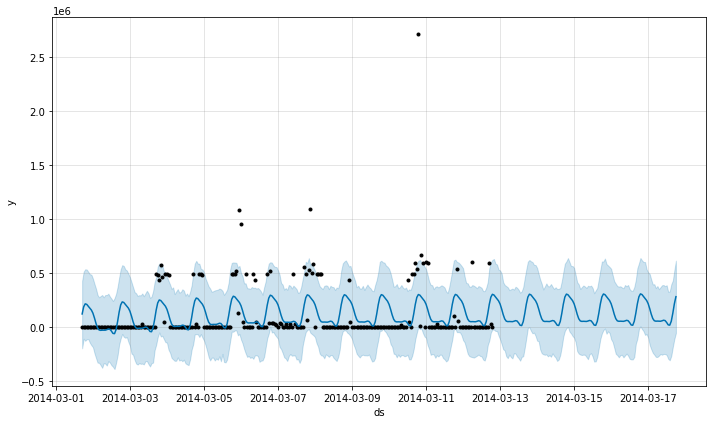

In [67]:
result = pd.concat([df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

In [68]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [69]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)

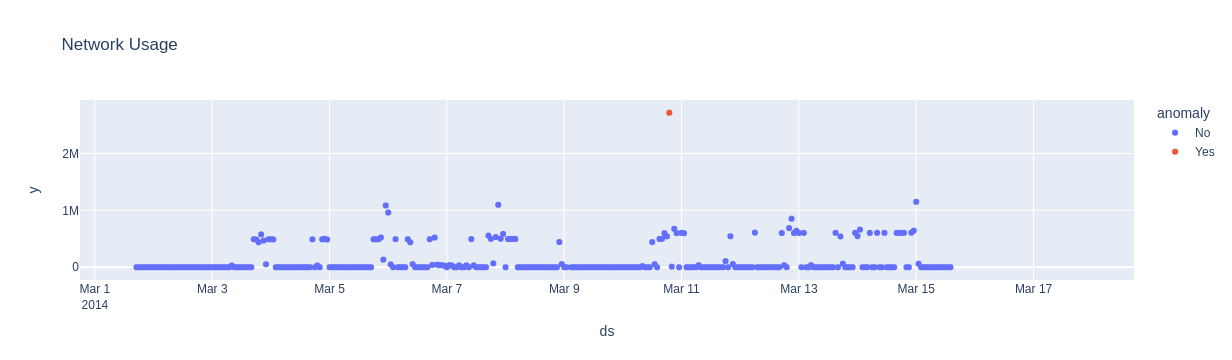

In [70]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Network Usage')
fig.show()